# Introduction

This notebook is designed to find the number of publication and all the citations for each hPSCs


# Set-Up

In [2]:
# set up
from google.colab import drive
drive.mount('/content/drive')

%run '/content/drive/My Drive/hPSC-FAIRness Analysis/scripts/setup_drive.py'

root_dir, data_dir, processed_dir, results_dir = setup_drive()

Mounted at /content/drive
Mounted at /content/drive
Setting up root directory with name: 'hPSC-FAIRness Analysis'
Root directory path: '/content/drive/My Drive/hPSC-FAIRness Analysis'


In [3]:
pip install pybliometrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 2.6 MB/s eta 0:00:00


In [4]:
# Load packages
import ast
import matplotlib.pyplot as plt
import pybliometrics
from pybliometrics.scopus import CitationOverview
import json
import numpy as np


# Load DataFrame
df = pd.read_excel(os.path.join(processed_dir,'Final.xlsx'))
Publication = pd.read_excel(os.path.join(results_dir,'Publication.xlsx'))
#df = pd.read_excel(os.path.join(results_dir,'Citation.xlsx'))

# The number of publications

In [5]:
# define a function to count the number of publications
def count_pubmed(value):
  if pd.isna(value):
    return 0
  elif isinstance(value, str):
    if value.startswith('['):
      converted_list = ast.literal_eval(value)
      return len(converted_list)
    else:
      return 1

In [6]:
# create a nw column in my df to store the results
df['PubMed_Count'] = df['RX'].apply(count_pubmed)
df = df[df['Published'] == True]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11675 entries, 4 to 21673
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   AC                    11675 non-null  object
 1   ID                    11675 non-null  object
 2   CA                    11675 non-null  object
 3   DR                    11643 non-null  object
 4   DT                    11675 non-null  object
 5   OX                    11675 non-null  object
 6   CC                    11664 non-null  object
 7   SX                    11599 non-null  object
 8   AG                    11452 non-null  object
 9   SY                    9310 non-null   object
 10  RX                    11675 non-null  object
 11  DI                    4522 non-null   object
 12  OI                    2868 non-null   object
 13  HI                    4355 non-null   object
 14  WW                    1100 non-null   object
 15  ST                    1117 non-null   obj

In [7]:
#df.to_excel(os.path.join(results_dir, 'Citation.xlsx'), index=False)

## Create Figures

- log scale

<ipython-input-8-da2fc8d23f37>:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_pub.legend(loc = 'center right', fontsize=6)


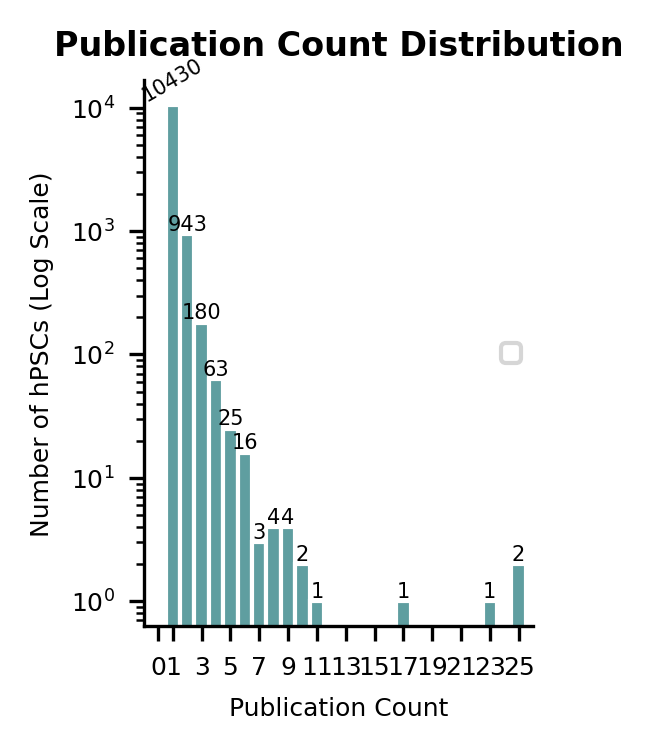

In [8]:
import matplotlib.pyplot as plt
import numpy as np
# --- Fixed figure size in mm ---
fig_width_inch = 85 / 2 / 25.4
fig_height_inch = 60 / 25.4
# Set figure size (width, height) in inches
#plt.figure(figsize=(fig_width_inch, fig_height_inch), dpi=300, constrained_layout=True)
fig_pub, ax_pub = plt.subplots(figsize=(fig_width_inch, fig_height_inch), dpi=300)
# Generate a histogram
counts, bins, patches = plt.hist(df['PubMed_Count'], bins=np.arange(-0.5, 26, 1),
                                 color='cadetblue', edgecolor='white', align='mid', label=None #cadetblue
)

# Set y-axis scale to logarithmic
plt.yscale('log')

# Label axes
plt.xlabel('Publication Count', fontsize=6)  # Set x-axis label with font size 9
plt.ylabel('Number of hPSCs (Log Scale)', fontsize=6)

# Add numbers above each bar with different rotations for the first two
for i, (count, patch) in enumerate(zip(counts, patches)):
    if count > 0:  # Only display if count is greater than 0
        rotation_angle = 30 if i < 2 else 0  # Rotate first two numbers, others stay normal
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom', fontsize=5, color='black', rotation=rotation_angle
                 )

# Set custom x-axis ticks (0, 1, 3, 5, ..., 25)
custom_ticks = [0] + list(range(1, 26, 2))  # Include 0 and odd numbers from 1 to 25
plt.xticks(custom_ticks, rotation=0, fontsize=6)
plt.yticks(fontsize=6)


# Remove top and right edges (spines)
ax_pub = plt.gca()  # Get current axis
ax_pub.spines['top'].set_visible(False)
ax_pub.spines['right'].set_visible(False)
ax_pub.legend(loc = 'center right', fontsize=6)

plt.xlim(-1, 26)  # Restrict axis to only show 0 to 25
ax_pub.set_title("Publication Count Distribution", fontsize = 8, fontweight = 'bold')
# Show plot
plt.show()


- normal scale

In [9]:
# Calculate median
median = df['PubMed_Count'].median()
print("Median:", median)

# Calculate mean
mean = df['PubMed_Count'].mean()
print("Mean:", mean)

# Calculate IQR
Q1 = df['PubMed_Count'].quantile(0.25)
Q3 = df['PubMed_Count'].quantile(0.75)
IQR = Q3 - Q1
print("IQR:", IQR)


Median: 1.0
Mean: 1.1596573875802998
IQR: 0.0


In [10]:
from scipy.stats import skew

# Assume your publication counts are stored as a list or array
pub_counts = df['PubMed_Count'].values

# Compute skewness
skewness_value = skew(pub_counts)

print(f"Skewness: {skewness_value:.2f}")

from scipy.stats import kurtosis
print(kurtosis(pub_counts))

print(np.percentile(pub_counts, [50, 75, 90, 99]))


Skewness: 14.50
393.09405714105696
[1. 1. 2. 4.]


# The Total Citations

## Create a Lookup dictionary for Citations

### Find the Unique PMIDs

In [11]:
# Set to store unique PubMed IDs
unique_pmids = set()

# Function to extract unique PubMed IDs
def extract_pubmed_ids(value):
    if pd.isna(value):  # Check for NaN
        return
    if isinstance(value, str):
        # Check if the value looks like a list
        if value.startswith('[') and value.endswith(']'):
            # Convert string representation of list to actual list
            entries = ast.literal_eval(value.strip())
        else:
            # Single string entry
            entries = [value]

        # Extract PubMed IDs and add to the set
        for entry in entries:
            if entry.startswith('PubMed='):
                pubmed_id = entry.split('=')[1].strip(';')  # Extract the ID
                unique_pmids.add(pubmed_id)

# Apply the function to each entry in the 'RX' column
df['RX'].apply(extract_pubmed_ids)

#print(unique_pmids)
print(len(unique_pmids))


3079


### Get the Citation through Scopus

This chunk of code takes a long time to execute. For convenience, I have saved the results in the file `Citation Lookup Dictionary.json` located in the `result_dir`. You can easily load this file for quicker access to the citation data.


- **Load Package**

In [12]:
# Load pybliometrics package
pybliometrics.scopus.init()

Creating config file at /root/.config/pybliometrics.cfg with default paths...
Please enter your API Key(s), obtained from http://dev.elsevier.com/myapikey.html.  Separate multiple keys by comma:
c12cccb940e6878cea9fefea0c215df7
API Keys are sufficient for most users.  If you have an InstToken, please enter the tokens pair now. Separate multiple tokens by a comma. The correspondig key's position should match the position of the token.If you don't have tokens, just press Enter:
2ab9a10b1d232330f0a66c2cee22b340
Configuration file successfully created at /root/.config/pybliometrics.cfg
For details see https://pybliometrics.rtfd.io/en/stable/configuration.html.


API Key: `c12cccb940e6878cea9fefea0c215df7`

Instance Token: `2ab9a10b1d232330f0a66c2cee22b340`

- **Load the Saved Citation Lookup Dictionary**

In [13]:
# Read the JSON file
with open(os.path.join(results_dir, 'Citation Lookup Dictionary.json'), 'r') as json_file:
    citation_dict = json.load(json_file)

- **Generate Citation Lookup Dictionary**

This chunk of code takes a long time to execute! If you load the dictionary already, don't execute this code!

In [14]:
'''
# Function to fetch citations with error handling
def Citation(CitationOverview, pubmed_id):
    try:
        result = CitationOverview([pubmed_id], id_type = "pubmed_id")
        return result.rowTotal[0]
    except Exception as e:
        #print(f"Scopus404Error: PubMed ID {pubmed_id} not found")
        return 'NA'

# The following code take a long time
citation_dict = {pubmed_id: Citation(CitationOverview, pubmed_id) for pubmed_id in unique_pmids}

# Save data to a JSON file
with open(os.path.join(results_dir, 'Citation Lookup Dictionary.json'), 'w') as json_file:
    json.dump(citation_dict, json_file)
'''

'\n# Function to fetch citations with error handling\ndef Citation(CitationOverview, pubmed_id):\n    try:\n        result = CitationOverview([pubmed_id], id_type = "pubmed_id")\n        return result.rowTotal[0]\n    except Exception as e:\n        #print(f"Scopus404Error: PubMed ID {pubmed_id} not found")\n        return \'NA\'\n\n# The following code take a long time\ncitation_dict = {pubmed_id: Citation(CitationOverview, pubmed_id) for pubmed_id in unique_pmids}\n\n# Save data to a JSON file\nwith open(os.path.join(results_dir, \'Citation Lookup Dictionary.json\'), \'w\') as json_file:\n    json.dump(citation_dict, json_file)\n'

- Statistics

In [15]:
# Count occurrences of 'NA'
count_na = sum(1 for value in citation_dict.values() if value == 'NA')
print(f'Number of PMIDs could not find an associated citation: {count_na}')

Number of PMIDs could not find an associated citation: 112


## Get the Publication Matrix through Scopus

This chunk of code takes a long time to execute. For convenience, I have saved the results in the fil `Publication.xlsx` located in the `result_dir`. You can easily load this file for quicker access to the citation data.

- **Load the Saved Publication Matrix (Optional)**

In [16]:
Publication = pd.read_excel(os.path.join(results_dir,'Publication.xlsx'))
Publication.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3079 entries, 0 to 3078
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PMID            3079 non-null   int64  
 1   Title           2971 non-null   object 
 2   Journal_Name    2971 non-null   object 
 3   Type            2971 non-null   object 
 4   Year            2971 non-null   float64
 5   Authors         2971 non-null   object 
 6   Publisher       2677 non-null   object 
 7   Funding         0 non-null      float64
 8   Citation_Count  2971 non-null   float64
dtypes: float64(3), int64(1), object(5)
memory usage: 216.6+ KB


- **Generate Publication Matrix**

This chunk of code takes around **20 minites** to execute! If you load the DataFrame already, don't execute this code!

In [17]:
'''
from pybliometrics.scopus import AbstractRetrieval
len(unique_pmids)
pmids = list(unique_pmids)

# Columns for the DataFrame
columns = ['PMID', 'Title', 'Journal_Name', 'Type', 'Year', 'Authors', 'Publisher', 'Funding']
data = []

# Loop over each PMID
for pmid in pmids:
    try:
        # Retrieve metadata using AbstractRetrieval
        ab = AbstractRetrieval(pmid)

        # Extract metadata fields
        title = ab.title
        journal_name = ab.publicationName
        pub_type = ab.aggregationType
        year = ab.coverDate[:4]
        authors = ab.authors
        publisher = ab.publisher
        funding = ab.funding

        # Append data as a list to the main data list
        data.append([pmid, title, journal_name, pub_type, year, authors, publisher, funding])

    except Exception as e:
        # If an error occurs, append None for all metadata fields for that PMID
        data.append([pmid, None, None, None, None, None, None, None])
        print(f"Error retrieving data for PMID {pmid}: {e}")

# Create the DataFrame
Publication = pd.DataFrame(data, columns=columns)

# Map publication count to Publication DataFrame
Publication['Citation_Count'] = Publication['PMID'].map(citation_dict)

# Save the DataFrame
Publication.to_excel(os.path.join(results_dir, 'Publication.xlsx'), index=False)
'''

'\nfrom pybliometrics.scopus import AbstractRetrieval\nlen(unique_pmids)\npmids = list(unique_pmids)\n\n# Columns for the DataFrame\ncolumns = [\'PMID\', \'Title\', \'Journal_Name\', \'Type\', \'Year\', \'Authors\', \'Publisher\', \'Funding\']\ndata = []\n\n# Loop over each PMID\nfor pmid in pmids:\n    try:\n        # Retrieve metadata using AbstractRetrieval\n        ab = AbstractRetrieval(pmid)\n\n        # Extract metadata fields\n        title = ab.title\n        journal_name = ab.publicationName\n        pub_type = ab.aggregationType\n        year = ab.coverDate[:4]\n        authors = ab.authors\n        publisher = ab.publisher\n        funding = ab.funding\n\n        # Append data as a list to the main data list\n        data.append([pmid, title, journal_name, pub_type, year, authors, publisher, funding])\n\n    except Exception as e:\n        # If an error occurs, append None for all metadata fields for that PMID\n        data.append([pmid, None, None, None, None, None, None, 

In [18]:
# Count how many entries had no result (Title is None)
no_result_count = Publication['Title'].isna().sum()
print(f"\nNumber of PMIDs with no results: {no_result_count}")


Number of PMIDs with no results: 108


## Create a citation dictionary for each hPSC

In [19]:
def Citation_dictionary(input_data):
  pubmed_dict = {}
  if isinstance(input_data,str):
    # Check if the input_data contains a list representation
    pubmed_dict={}
    if '[' in input_data and ']' in input_data:
      # Use ast.literal_eval() to safely evaluate the string representation to a list
        input_list = ast.literal_eval(input_data)
        # Process the list if it starts with 'PubMed='
        for line in input_list:
          pubmed_id = line.split('=')[1].rstrip(';')
          pubmed_dict[pubmed_id] = citation_dict.get(pubmed_id, None)
    # Process the string if it starts with 'PubMed='
    elif input_data.startswith('PubMed='):
        pubmed_id = input_data.split('=')[1].rstrip(';')
        pubmed_dict[pubmed_id] = citation_dict.get(pubmed_id, None)
    return pubmed_dict

In [20]:
df['Citation_dict'] = df['RX'].apply(Citation_dictionary)

## Calculate the sum of citations for each hPSC

In [21]:
def sum_citations(citation_dict):
    """Sum only numeric values in a citation dictionary. Skip 'NA' or non-numeric values."""
    if citation_dict and isinstance(citation_dict, dict):
        return sum(
            value for value in citation_dict.values()
            if isinstance(value, (int, float)) and not pd.isna(value)
        )
    return 0

# Apply the sum_citations function to create a new column 'Sum_Citations'
df['Sum_Citations'] = df['Citation_dict'].apply(sum_citations)

- **Store the Results**

In [22]:
# save file to drive
#df.to_excel(os.path.join(results_dir, 'Citation.xlsx'), index=False)

## Create Figures

In [23]:
df = pd.read_excel(os.path.join(results_dir,'Citation.xlsx'))
#df = df[df['RX'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11675 entries, 0 to 11674
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   AC                    11675 non-null  object
 1   ID                    11675 non-null  object
 2   CA                    11675 non-null  object
 3   DR                    11643 non-null  object
 4   DT                    11675 non-null  object
 5   OX                    11675 non-null  object
 6   CC                    11664 non-null  object
 7   SX                    11599 non-null  object
 8   AG                    11452 non-null  object
 9   SY                    9310 non-null   object
 10  RX                    11675 non-null  object
 11  DI                    4522 non-null   object
 12  OI                    2868 non-null   object
 13  HI                    4355 non-null   object
 14  WW                    1100 non-null   object
 15  ST                    1117 non-null 

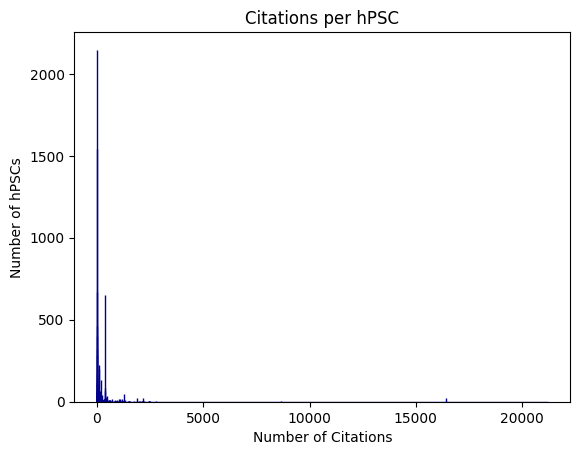

In [24]:
#import matplotlib.pyplot as plt
# Plot histogram
plt.hist(df['Sum_Citations'], bins = range(0,21211), edgecolor='darkblue')
plt.xlabel('Number of Citations')
plt.ylabel('Number of hPSCs')
plt.title('Citations per hPSC')
plt.show()

In [25]:
# Calculate median
median = df['Sum_Citations'].median()
print(median)
# Calculate IQR
Q1 = df['Sum_Citations'].quantile(0.25)
Q3 = df['Sum_Citations'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

20.0
103.0


In [26]:
# Calculate median
median = df['Sum_Citations'].median()
print("Median:", median)

# Calculate mean
mean = df['Sum_Citations'].mean()
print("Mean:", mean)

# Calculate IQR
Q1 = df['Sum_Citations'].quantile(0.25)
Q3 = df['Sum_Citations'].quantile(0.75)
IQR = Q3 - Q1
print("IQR:", IQR)



from scipy.stats import skew

# Assume your publication counts are stored as a list or array
cit_counts = df['Sum_Citations'].values

# Compute skewness
skewness_value = skew(cit_counts)

print(f"Skewness: {skewness_value:.2f}")

from scipy.stats import kurtosis
print(kurtosis(cit_counts))

print(np.percentile(cit_counts, [50, 75, 90, 95, 97, 99]))



Median: 20.0
Mean: 169.4204710920771
IQR: 103.0
Skewness: 16.10
290.36840115336713
[  20.    106.    361.    463.    969.   1944.98]


In [27]:
bins = [0, 1, 10, 100, 1000, 10000, float('inf')]
labels = ['0', '1-10', '10–100', '100–1000', '1000–10000', '>10000']

# Right-inclusive: includes the upper bound in each bin
df['Citation_Range'] = pd.cut(df['Sum_Citations'], bins=bins, labels=labels, right=False)
# Count number of hPSC lines in each bin
range_counts = df['Citation_Range'].value_counts().sort_index()

print(range_counts)

Citation_Range
0             1544
1-10          2642
10–100        4510
100–1000      2632
1000–10000     319
>10000          28
Name: count, dtype: int64


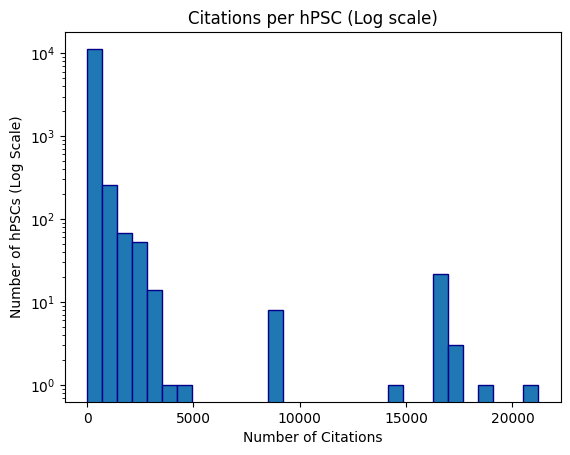

In [28]:
# Plot histogram with logarithmic y-axis
plt.hist(df['Sum_Citations'], bins = 30, edgecolor='darkblue')
plt.yscale('log')
plt.xlabel('Number of Citations')
plt.ylabel('Number of hPSCs (Log Scale)')
plt.title('Citations per hPSC (Log scale)')
plt.show()

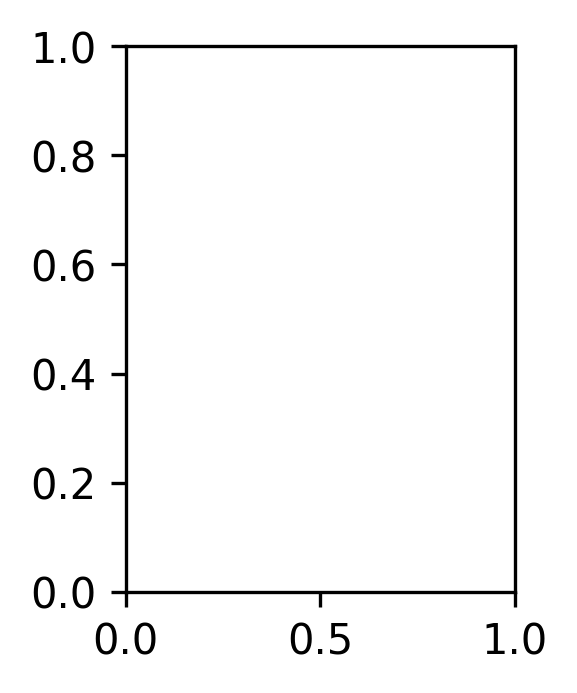

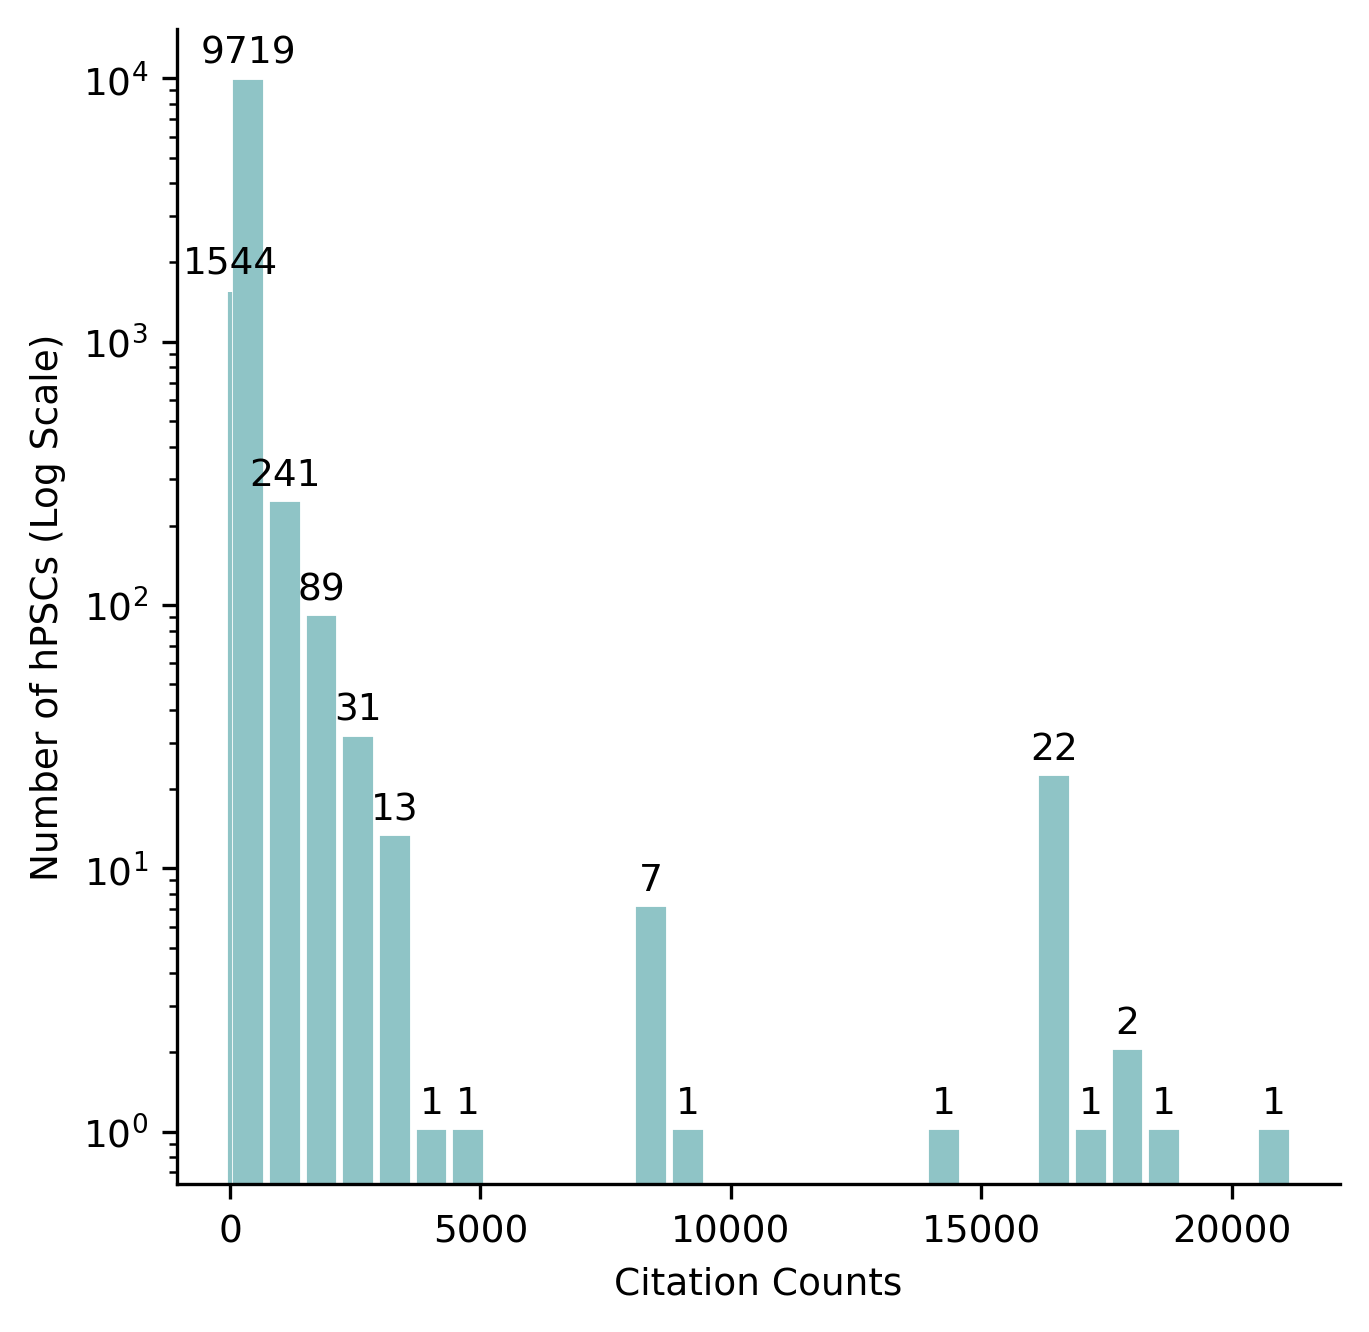

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# --- Fixed figure size in mm ---
fig_width_inch = 85 / 2 / 25.4
fig_height_inch = 60 / 25.4
# Set figure size (width, height) in inches
#plt.figure(figsize=(fig_width_inch, fig_height_inch), dpi=300, constrained_layout=True)
fig_cit, ax_cit = plt.subplots(figsize=(fig_width_inch, fig_height_inch), dpi=300)

# Extract citation data
citations = df['Sum_Citations'].values

# Define custom bins
bins = np.concatenate(([0], np.linspace(1, max(citations), num=30)))

# Compute histogram data
counts, bin_edges = np.histogram(citations, bins=bins)

# Compute bin centers for proper alignment
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Adjust bar width based on bin spacing
bar_widths = np.diff(bin_edges) * 0.7

# Set figure size
plt.figure(figsize=(5, 5), dpi=300)

# Create vertical bar chart
plt.bar(bin_centers, counts, width=bar_widths, color='#8FC4C6', edgecolor='#8FC4C6')

# Set log scale for y-axis only
plt.yscale('log')

# Label axes
plt.xlabel('Citation Counts', fontsize=9)
plt.ylabel('Number of hPSCs (Log Scale)', fontsize=9)

# Show numbers above bars
for x, count, w in zip(bin_centers, counts, bar_widths):
    if count > 0:
        plt.text(x, count * 1.1, int(count), ha='center', va='bottom', fontsize=9)

# Format ticks
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Remove top and right spines
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)

# Show plot
plt.show()


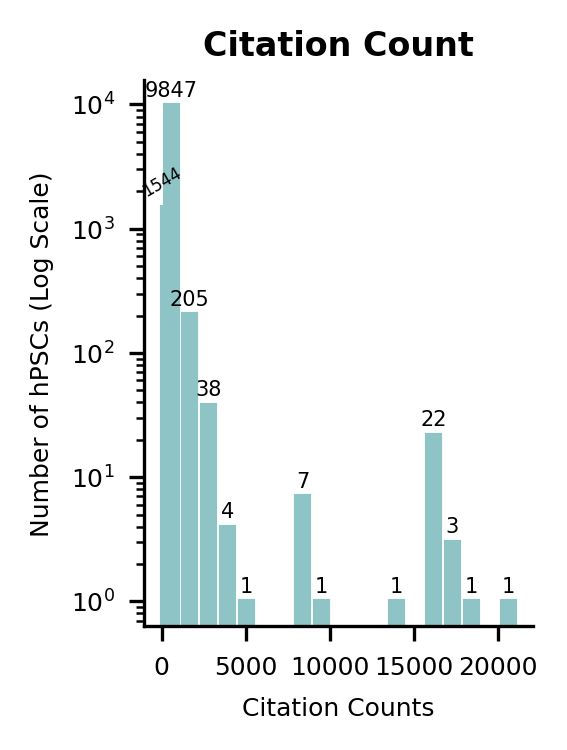

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# --- Fixed figure size in mm ---
fig_width_inch = 85 / 2 / 25.4
fig_height_inch = 60 / 25.4

# Create figure and axis
fig_cit, ax_cit = plt.subplots(figsize=(fig_width_inch, fig_height_inch), dpi=300)

# Extract citation data
citations = df['Sum_Citations'].values

# Define custom bins
bins = np.concatenate(([0], np.linspace(1, max(citations), num=20)))

# Compute histogram data
counts, bin_edges = np.histogram(citations, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bar_widths = np.diff(bin_edges) * 0.7

# Plot histogram
bars = ax_cit.bar(bin_centers, counts, width=bar_widths, color='#8FC4C6', edgecolor='#8FC4C6', label=None)

# Set log scale for y-axis
ax_cit.set_yscale('log')

# Label axes
ax_cit.set_xlabel('Citation Counts', fontsize=6)
ax_cit.set_ylabel('Number of hPSCs (Log Scale)', fontsize=6)

for i, (x, count) in enumerate(zip(bin_centers, counts)):
    if count > 0:
        rotation_angle = 30 if i == 0 else 0
        x_shift = x + bar_widths[i] * 0.2 if i == 0 else x
        font_size = 4 if i == 0 else 5
        ax_cit.text(x_shift, count * 1.1, int(count),
                    ha='center', va='bottom', fontsize=font_size, color='black', rotation=rotation_angle)


# Set custom ticks
ax_cit.tick_params(axis='x', labelsize=6)
ax_cit.tick_params(axis='y', labelsize=6)

# Remove top and right spines
ax_cit.spines['top'].set_visible(False)
ax_cit.spines['right'].set_visible(False)

# Optional: Add legend if needed
# ax_cit.legend(loc='center right', fontsize=6)

# Optional: Add title
ax_cit.set_title("Citation Count", fontsize=8, fontweight='bold')

# Show plot
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


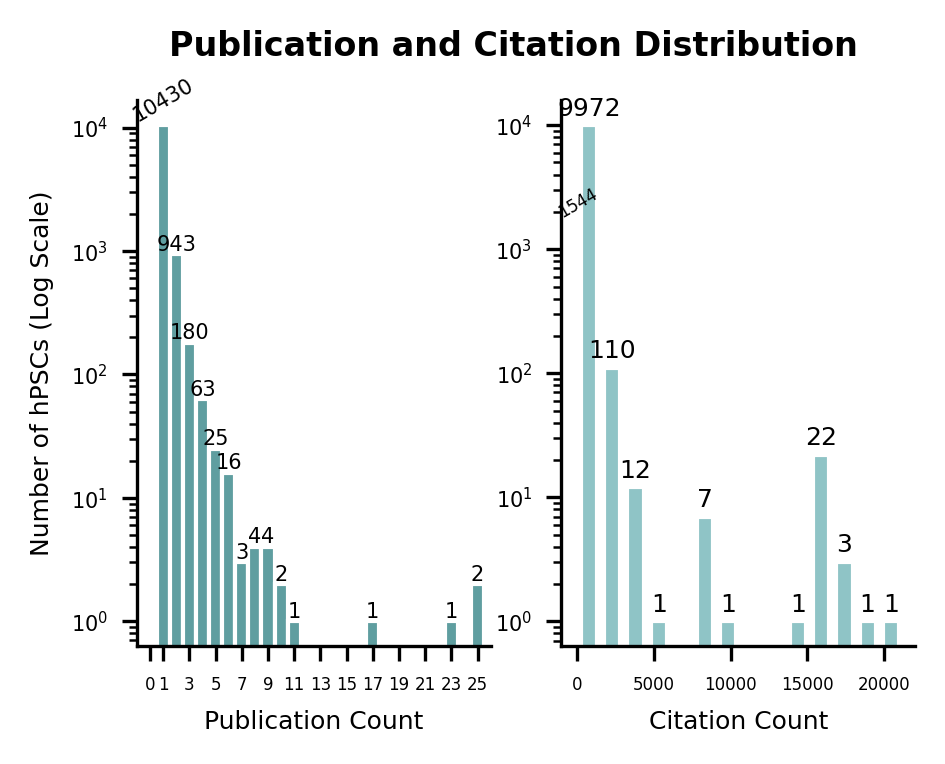

In [31]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Fixed figure size
fig_width_inch = 85 / 25.4
fig_height_inch = 60 / 25.4

# Create combined figure and grid
fig = plt.figure(figsize=(fig_width_inch, fig_height_inch), dpi=300, constrained_layout=True)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Instead of fig_pub, reuse the plotting code and draw onto ax_pub
ax_pub = fig.add_subplot(gs[0])

# Plot 1: Publication Count
counts, bins, patches = ax_pub.hist(df['PubMed_Count'], bins=np.arange(-0.5, 26, 1),
                                    color='cadetblue', edgecolor='white', align='mid')

ax_pub.set_yscale('log')
ax_pub.set_xlabel('Publication Count', fontsize=6)
ax_pub.set_ylabel('Number of hPSCs (Log Scale)', fontsize=6)
for i, (count, patch) in enumerate(zip(counts, patches)):
    if count > 0:
        rotation_angle = 30 if i < 2 else 0
        ax_pub.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                    ha='center', va='bottom', fontsize=5, rotation=rotation_angle)
ax_pub.set_xticks([0] + list(range(1, 26, 2)))
ax_pub.tick_params(axis='x', labelsize=4)
ax_pub.tick_params(axis='y', labelsize=5)
ax_pub.spines[['top', 'right']].set_visible(False)
ax_pub.set_xlim(-1, 26)
#ax_pub.set_title("Publication Distribution", fontsize=8, fontweight='bold')

# Instead of fig_cit, reuse code and draw onto ax_cit
ax_cit = fig.add_subplot(gs[1])

# Plot 2: Citation Count
citations = df['Sum_Citations'].values
bins = np.concatenate(([0], np.linspace(1, max(citations), num=15)))
counts, bin_edges = np.histogram(citations, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bar_widths = np.diff(bin_edges) * 0.7

ax_cit.bar(bin_centers, counts, width=bar_widths, color='#8FC4C6', edgecolor='white')
ax_cit.set_yscale('log')
ax_cit.set_xlabel('Citation Count', fontsize=6)
#ax_cit.set_ylabel('Number of hPSCs (Log Scale)', fontsize=6)
for i, (x, count) in enumerate(zip(bin_centers, counts)):
    if count > 0:
        rotation_angle = 30 if i == 0 else 0
        x_shift = x + bar_widths[i] * 0.2 if i == 0 else x
        font_size = 4 if i == 0 else 6
        ax_cit.text(x_shift, count * 1.1, int(count),
                    ha='center', va='bottom', fontsize=font_size, rotation=rotation_angle)
ax_cit.tick_params(axis='x', labelsize=4)
ax_cit.tick_params(axis='y', labelsize=5)
ax_cit.spines[['top', 'right']].set_visible(False)
#ax_cit.set_title("Citation Distribution", fontsize=8, fontweight='bold')

fig.suptitle('Publication and Citation Distribution', fontsize=8, fontweight='bold')
# Show combined figure
plt.show()


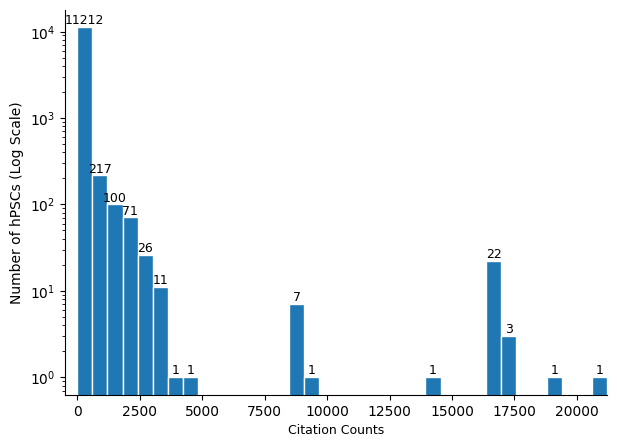

In [32]:
import matplotlib.pyplot as plt

# Set figure size (width, height) in inches
plt.figure(figsize=(7,5))
# Plot histogram with logarithmic y-axis
counts, bins, patches = plt.hist(df['Sum_Citations'], bins=35, edgecolor='white', align='mid')
plt.yscale('log')
plt.xlabel('Citation Counts', fontsize=9)
plt.ylabel('Number of hPSCs (Log Scale)')
#plt.title('Citations per hPSC (Log scale)')

# Label the number on top of each bar
for count, x in zip(counts, bins):
    # If the count is greater than 0, label it
    if count > 0:
        plt.text(x + (bins[1] - bins[0]) / 2, count, int(count), ha='center', va='bottom', fontsize=9, color='black')

# Remove top and right edges (spines)
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim(-500, 21209)  # Restrict axis to only show 0 to 25
#plt.title('Citations per hPSC')
plt.show()


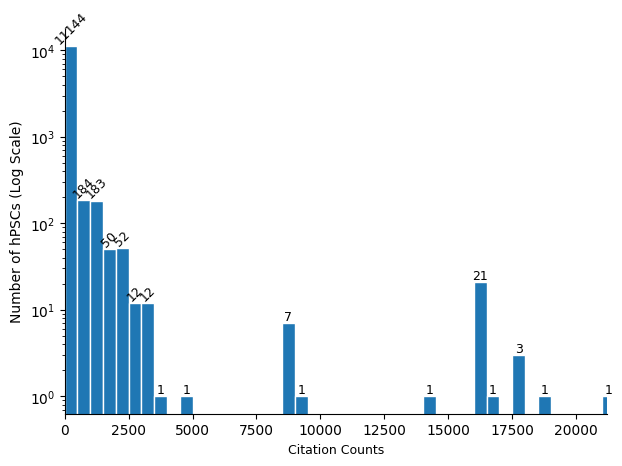

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure size (width, height) in inches
plt.figure(figsize=(7, 5))

# Plot histogram with logarithmic y-axis
counts, bins, patches = plt.hist(df['Sum_Citations'], bins=np.arange(0, 21709, 500), edgecolor='white', align='mid')
plt.yscale('log')

# Label axes
plt.xlabel('Citation Counts', fontsize=9)
plt.ylabel('Number of hPSCs (Log Scale)')

# Compute bin centers for better alignment
#bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2  # Midpoints of bins


# Add numbers above each bar with different rotations for the first two
for i, (count, patch) in enumerate(zip(counts, patches)):
    if count > 0:  # Only display if count is greater than 0
        rotation_angle = 45 if i < 7 else 0  # Rotate first two numbers, others stay normal
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom', fontsize=9, color='black', rotation=rotation_angle)

# Remove top and right edges (spines)
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set x-axis range dynamically based on data
plt.xlim(0, max(df['Sum_Citations']))  # Auto-adjusts to citation data

# Format x-ticks to improve readability (e.g., use thousands separator)
plt.ticklabel_format(style='plain', axis='x')  # Prevents scientific notation
plt.xticks(rotation=0)  # Keep x-axis ticks horizontal

# Set custom x-axis ticks (0, 1, 3, 5, ..., 25)
custom_ticks = [0] + [1] + list(range(2, 21209, 500))  # Include 0 and odd numbers from 1 to 25


# Show plot
plt.show()


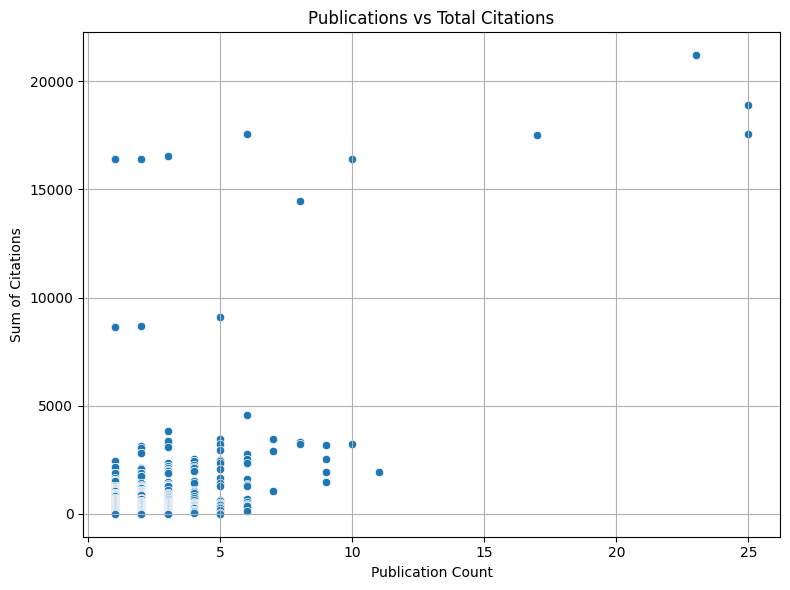

In [34]:
import seaborn as sns
#import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PubMed_Count', y='Sum_Citations')

plt.title('Publications vs Total Citations')
plt.xlabel('Publication Count')
plt.ylabel('Sum of Citations')
plt.grid(True)
plt.tight_layout()
plt.show()


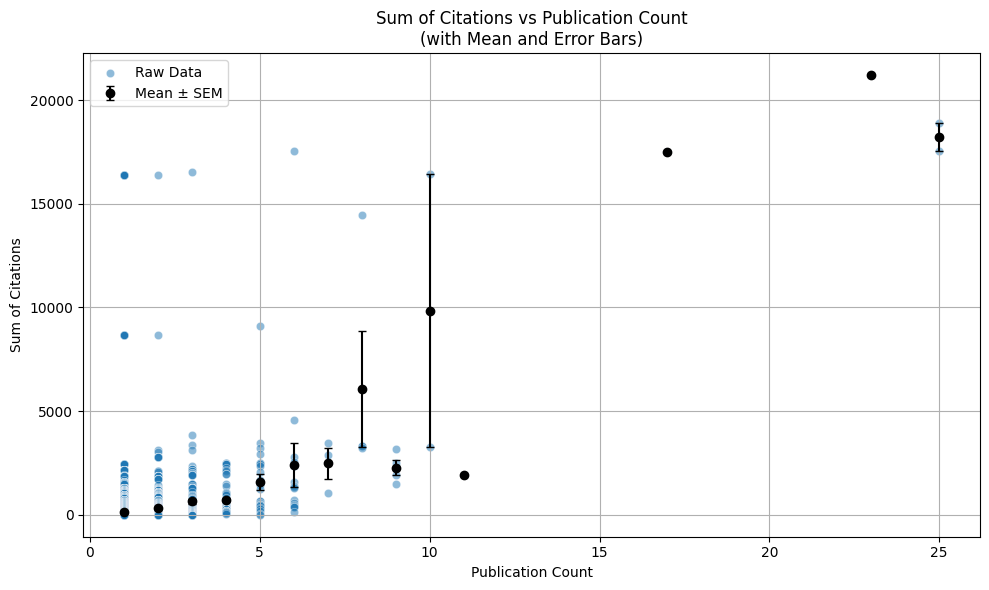

In [35]:
import pandas as pd

# Group by Publication Count
summary_stats = df.groupby('PubMed_Count')['Sum_Citations'].agg(['mean', 'std', 'count'])

# Calculate standard error
summary_stats['sem'] = summary_stats['std'] / summary_stats['count']**0.5

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Raw scatter plot
sns.scatterplot(data=df, x='PubMed_Count', y='Sum_Citations', alpha=0.5, label='Raw Data')

# Mean + error bars
plt.errorbar(
    summary_stats.index,
    summary_stats['mean'],
    yerr=summary_stats['sem'],  # or use 'std' if you want full spread
    fmt='o',
    color='black',
    capsize=3,
    label='Mean ± SEM'
)


plt.title('Sum of Citations vs Publication Count\n(with Mean and Error Bars)')
plt.xlabel('Publication Count')
plt.ylabel('Sum of Citations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
# Assume linerity
from scipy.stats import pearsonr

corr, pval = pearsonr(df['PubMed_Count'], df['Sum_Citations'])
print(f"Pearson correlation = {corr:.3f}, p-value = {pval:.4e}")


Pearson correlation = 0.393, p-value = 0.0000e+00


In [37]:
# Spearman's rank correlation without assuming linearity
from scipy.stats import spearmanr

rho, pval = spearmanr(df['PubMed_Count'], df['Sum_Citations'])
print(f"Spearman correlation = {rho:.3f}, p-value = {pval:.4e}")


Spearman correlation = 0.293, p-value = 1.1372e-229


In [38]:
# Define the ranges of interest
ranges = [(0, 0), (0,1), (1, 10), (10, 100), (100, 1000), (1000, 10000), (10000, float('inf'))]

# Calculate the number of lines in each range, including zero citations
for lower, upper in ranges:
    if lower == 0 and upper == 0:
        count = df[df['Sum_Citations'] == 0].shape[0]
        print(f'Number of hPSCs with exactly {lower} citations: {count}')
    else:
        count = df[(df['Sum_Citations'] > lower) & (df['Sum_Citations'] <= upper)].shape[0]
        print(f'Number of hPSCs with citations between {lower} and {upper}: {count}')


Number of hPSCs with exactly 0 citations: 1544
Number of hPSCs with citations between 0 and 1: 669
Number of hPSCs with citations between 1 and 10: 2084
Number of hPSCs with citations between 10 and 100: 4404
Number of hPSCs with citations between 100 and 1000: 2627
Number of hPSCs with citations between 1000 and 10000: 319
Number of hPSCs with citations between 10000 and inf: 28


# Journal name

## Create a Journal dictionary for each hPSC

In [39]:
def extract_all_pubmed_ids(input_data):
    """Extract all PubMed IDs from a given input string or list-like string."""
    pubmed_ids = []
    if isinstance(input_data, str):
        # Handle list-like string
        if '[' in input_data and ']' in input_data:
            try:
                input_list = ast.literal_eval(input_data)
                for line in input_list:
                    if line.startswith('PubMed='):
                        pubmed_id = line.split('=')[1].rstrip(';')
                        pubmed_ids.append(pubmed_id)
            except (SyntaxError, ValueError):
                return []
        # Handle single "PubMed=" string
        elif input_data.startswith('PubMed='):
            pubmed_id = input_data.split('=')[1].rstrip(';')
            pubmed_ids.append(pubmed_id)
    return pubmed_ids

In [40]:
# Load both Excel files
final_df = pd.read_excel(os.path.join(processed_dir,'Final.xlsx'))
publication_df = pd.read_excel(os.path.join(results_dir,'Publication.xlsx'))

# Convert PMID to strings to ensure consistent matching
publication_df['PMID'] = publication_df['PMID'].astype(str)

# Extract all PubMed IDs from the 'RX' column
final_df['PubMed_IDs'] = final_df['RX'].apply(extract_all_pubmed_ids)

# Initialize a new column to store matched journal names
final_df['Journal_Names'] = None


In [41]:
# Create a lookup dictionary for PubMed IDs to journal names
pubmed_to_journal = publication_df.set_index('PMID')['Journal_Name'].to_dict()
print(pubmed_to_journal)

{'15645084': 'Acta Biochimica et Biophysica Sinica', '23836290': 'Acta Neuropathologica', '27402089': 'Acta Neuropathologica Communications', '24398250': 'Acta Neuropathologica Communications', '25567319': 'Aging', '32981093': 'Alcoholism: Clinical and Experimental Research', '30045758': "Alzheimer's Research and Therapy", '30075114': 'American Journal of Human Genetics', '37541189': 'American Journal of Human Genetics', '22425713': 'American Journal of Pathology', '30032658': 'Amyloid', '21721033': 'Annals of Neurology', '37679035': 'Annals of the Rheumatic Diseases', '33660062': 'Archives of Toxicology', '28610919': 'Biochemical and Biophysical Research Communications', '31221065': 'Biochemistry (Moscow)', '20555390': 'Biochemistry and Cell Biology', '35569737': 'Biochimica et Biophysica Acta - Molecular Basis of Disease', '15317691': 'Biology of Reproduction', '12930726': 'Biology of Reproduction', '28453617': 'Biology of Reproduction', '33268331': 'Biology Open', '24268663': 'Bioma

In [42]:
publication_df['Journal_Name'].isna().sum() # missing value for Journal Name

np.int64(108)

In [43]:
# Function to match PubMed IDs to journal names and return a list
def match_journal_names(pubmed_ids):
    if pubmed_ids:
        return [pubmed_to_journal.get(pubmed_id) for pubmed_id in pubmed_ids if pubmed_id in pubmed_to_journal]
    return []

# Apply the matching function to populate the 'Journal_Names' column
final_df['Journal_Names'] = final_df['PubMed_IDs'].apply(match_journal_names)

# Save the result to a new Excel file
#final_df.to_excel(os.path.join(results_dir, 'Final_with_Journal_Names.xlsx'), index=False)

# Optional: Preview the DataFrame
#print(final_df[['RX', 'Journal_Names']].head())


In [44]:
# Sample 'Journal_Names' column from final_df
# Example structure: [['Journal A', 'Journal B'], ['Journal C'], ['Journal A', 'Journal C']]
# Ensure 'Journal_Names' is filled with lists

final_df['Journal_Names'] = final_df['Journal_Names'].apply(lambda x: x if isinstance(x, list) else [])

# Step 1: Get a unique list of all journal names
unique_journals = set([journal for sublist in final_df['Journal_Names'] for journal in sublist])



In [45]:
print(unique_journals)

{'Journal of Comparative Neurology', 'Leukemia Research', 'American Journal of Pathology', 'Molecular Neurobiology', 'Methods in Molecular Biology', 'Pain', 'Biochimica et Biophysica Acta - Molecular Basis of Disease', 'American Journal of Human Genetics', 'Methods in Cell Biology', 'Stem Cell Reviews and Reports', 'The Tohoku journal of experimental medicine', 'Restorative Neurology and Neuroscience', 'Nature Genetics', 'BMC Genomics', 'Acta Neuropathologica Communications', 'Science Translational Medicine', 'Molecular Psychiatry', 'Orphanet Journal of Rare Diseases', 'Europace', 'Proceedings of the Japan Academy Series B: Physical and Biological Sciences', 'Journal of Experimental Medicine', 'Diabetes', 'eLife', 'Archives of Toxicology', 'Brain and Development', 'Cellular Physiology and Biochemistry', 'Amyloid', 'Pediatrics International', 'European Journal of Neuroscience', 'Annals of Neurology', 'Stem Cells', 'Nucleic Acids Research', 'Brazilian Journal of Biology', 'Journal of Ass

In [46]:
# Step 2: Create new columns for each unique journal
for journal in unique_journals:
    # Create a new column for each journal
    final_df[journal] = final_df['Journal_Names'].apply(lambda x: 'Yes' if journal in x else 'No')

# Optional: Preview the DataFrame
#print(final_df.head())

# Save the result to a new Excel file
#final_df.to_excel(os.path.join(results_dir, 'Final_with_Journal_Names.xlsx'), index=False)

<ipython-input-46-358c78ba9d13>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df[journal] = final_df['Journal_Names'].apply(lambda x: 'Yes' if journal in x else 'No')
<ipython-input-46-358c78ba9d13>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df[journal] = final_df['Journal_Names'].apply(lambda x: 'Yes' if journal in x else 'No')
<ipython-input-46-358c78ba9d13>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

In [67]:
# Ensure full output display without truncation
#pd.set_option('display.max_rows', None)

#final_df = pd.read_excel(os.path.join(results_dir, 'Final_with_Journal_Names.xlsx'))

# Flatten the 'Journal_Names' lists and count frequencies
journal_frequency = pd.Series([journal for sublist in final_df['Journal_Names'] for journal in sublist]).value_counts()

# Display the frequency table
print("Journal Frequency Table:")
print(journal_frequency)


Journal Frequency Table:
Stem Cell Research                                                                 3842
Cell Reports                                                                       2329
Nature                                                                             1094
Cell Stem Cell                                                                      805
Stem Cell Reports                                                                   751
PLoS ONE                                                                            301
In Vitro Cellular and Developmental Biology - Animal                                206
Cell                                                                                194
Stem Cells                                                                          168
Stem Cells and Development                                                          158
Scientific Reports                                                                  155
Nature 

In [48]:
total_mentions = journal_frequency.sum()
print(f"Total journal mentions: {total_mentions}")


Total journal mentions: 12544


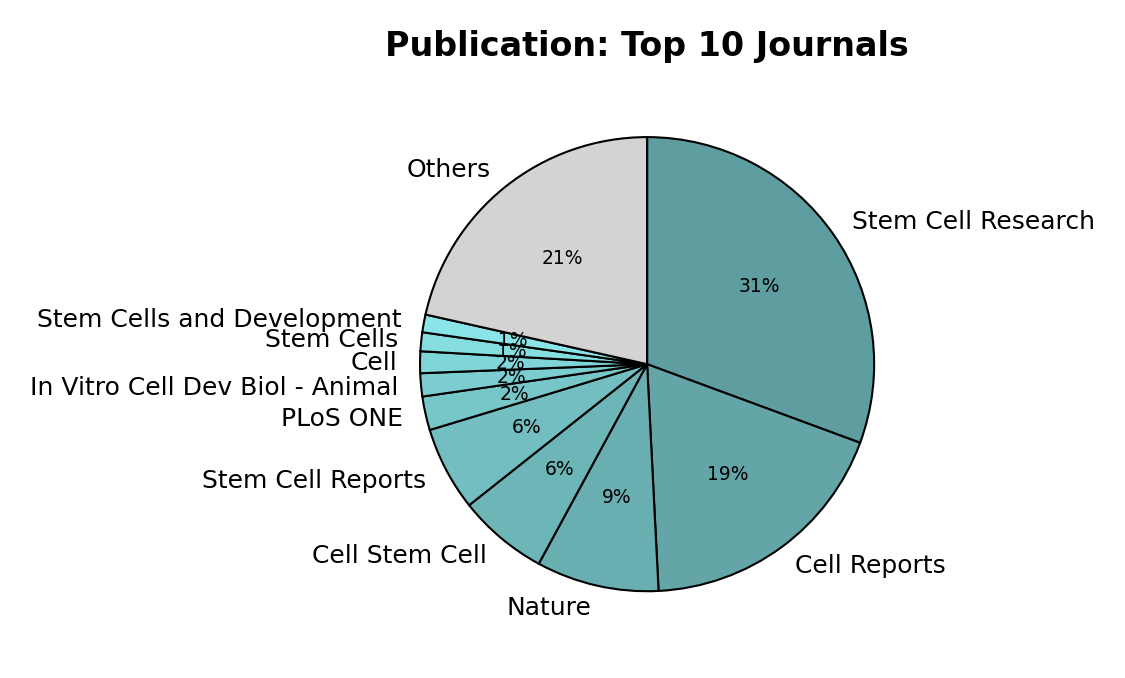

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import colors as mcolors

# Rename long journal name globally
journal_frequency = journal_frequency.rename(index={
    'Proceedings of the National Academy of Sciences of the United States of America': 'PNAS',
    'In Vitro Cellular and Developmental Biology - Animal': 'In Vitro Cell Dev Biol - Animal'
})

# Get top 10 + 'Others'
top_10 = journal_frequency.head(10)
others_count = journal_frequency.iloc[10:].sum()
journal_counts_for_plot = pd.concat([top_10, pd.Series({'Others': others_count})])

# Create cadet blue shades
base_color = np.array(mcolors.to_rgb('cadetblue'))
shades = [base_color * (1 + i * 0.05) for i in range(10)]  # lighten each step
shades = [np.clip(c, 0, 1) for c in shades]  # ensure RGB stays valid
shades = [mcolors.to_hex(c) for c in shades]

# Final color list: cadetblue shades + grey for 'Others'
colors = shades + ['lightgrey']

# Plot
fig, ax = plt.subplots(figsize=(85 / 25.4, 60 / 25.4), dpi=300)

wedges, texts, autotexts = ax.pie(
    journal_counts_for_plot,
    labels=journal_counts_for_plot.index,
    autopct='%1.0f%%',
    startangle=90,
    counterclock=False,
    colors=colors,
    wedgeprops={'edgecolor': 'black','linewidth': 0.5},
    textprops={'fontsize': 6}
)

for autotext in autotexts:
    autotext.set_fontsize(4.5)

plt.title('Publication: Top 10 Journals', fontsize=8, fontweight='bold')
plt.tight_layout()
plt.show()


In [51]:
# Filter rows based on criteria: 'registered' == 'Yes' and 'banked' == 'No'
#filtered_df = final_df[(final_df['Registered'] == True)]

# Filter rows based on criteria: 'registered' == 'Yes' and 'banked' == 'No'
filtered_df = final_df[(final_df['hPSCreg'] == 'yes')]

# Flatten the 'Journal_Names' lists and count frequencies
journal_frequency = pd.Series([journal for sublist in filtered_df['Journal_Names'] for journal in sublist]).value_counts()

# Display the frequency table
print("Journal Frequency Table:")
print(journal_frequency)

Journal Frequency Table:
Stem Cell Research                                      3440
Nature                                                   487
In Vitro Cellular and Developmental Biology - Animal     155
Stem Cell Reports                                        126
Cell Reports                                             112
                                                        ... 
Theranostics                                               1
Brain Research                                             1
Molecular Metabolism                                       1
Experimental Cell Research                                 1
Circulation Research                                       1
Name: count, Length: 132, dtype: int64


In [52]:
# Filter rows based on criteria: 'registered' == 'Yes' and 'banked' == 'No'
#filtered_df = final_df[(final_df['Registered'] == False)]

# Flatten the 'Journal_Names' lists and count frequencies
#journal_frequency = pd.Series([journal for sublist in filtered_df['Journal_Names'] for journal in sublist]).value_counts()

# Display the frequency table
#print("Journal Frequency Table:")
#print(journal_frequency)

Journal Frequency Table:
Cell Reports                                                              2177
Cell Stem Cell                                                             442
Nature                                                                     436
Stem Cell Research                                                         319
Stem Cell Reports                                                          232
                                                                          ... 
Cell Communication and Signaling                                             1
BioMedical Engineering Online                                                1
European Respiratory Journal                                                 1
Philosophical Transactions of the Royal Society B: Biological Sciences       1
Cytotherapy                                                                  1
Name: count, Length: 128, dtype: int64


# Publication: Year vs Citation

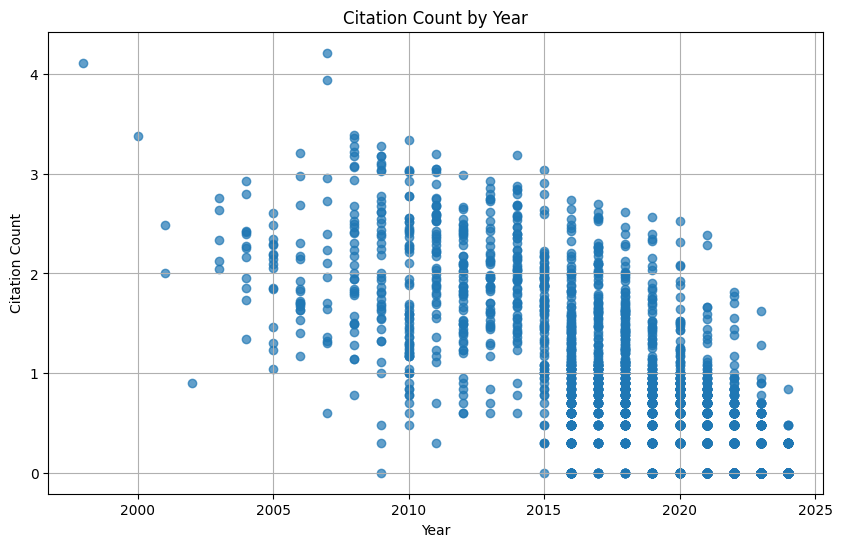

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(Publication['Year'], np.log10(Publication['Citation_Count']+1), alpha=0.7)

plt.title('Citation Count by Year')
plt.xlabel('Year')
plt.ylabel('Citation Count')
plt.grid(True)
plt.show()


In [55]:
# The top 3 dots seem like outliers, Let me remove them!
# their PMIDs are
#'18035408'
#'9804556'
#'18029452'
# List of PMIDs to remove
pmids_to_remove = [18035408, 9804556, 18029452]

# Filter the DataFrame
Publication_filtered = Publication[~Publication['PMID'].isin(pmids_to_remove)].copy()

In [56]:
import statsmodels.api as sm

# Drop rows with NaN in either 'Year' or 'Citation_Count'
df_clean = Publication[['Year', 'Citation_Count']].dropna()
# Drop rows with NaN in either 'Year' or 'Citation_Count'
#df_clean = Publication_filtered[['Year', 'Citation_Count']].dropna() ## after I drop outliers, 'Year' is more significant

X = df_clean['Year']
y = df_clean['Citation_Count']
X = sm.add_constant(X)  # adds intercept

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         Citation_Count   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     224.2
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           6.44e-49
Time:                        06:48:47   Log-Likelihood:                -22244.
No. Observations:                2971   AIC:                         4.449e+04
Df Residuals:                    2969   BIC:                         4.450e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.597e+04   3734.503     14.988      0.0

In [57]:
import statsmodels.api as sm

# Drop rows with NaN in either 'Year' or 'Citation_Count'
df_clean = Publication[['Year', 'Citation_Count']].dropna()
# Drop rows with NaN in either 'Year' or 'Citation_Count'
#df_clean = Publication_filtered[['Year', 'Citation_Count']].dropna() ## after I drop outliers, 'Year' is more significant

X = df_clean['Year']
y = np.log10(df_clean['Citation_Count']+1)
X = sm.add_constant(X)  # adds intercept

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         Citation_Count   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     3971.
Date:                Mon, 31 Mar 2025   Prob (F-statistic):               0.00
Time:                        06:48:47   Log-Likelihood:                -2103.9
No. Observations:                2971   AIC:                             4212.
Df Residuals:                    2969   BIC:                             4224.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        268.4839      4.248     63.202      0.0

In [58]:
model.f_pvalue

np.float64(0.0)

In [59]:
import statsmodels.api as sm
import pandas as pd

# Drop NaNs from the required columns
df_clean = Publication[['Year', 'Citation_Count', 'Journal_Name']].dropna()

# Convert 'Year' and 'Citation_Count' to numeric (if not already)
df_clean['Year'] = pd.to_numeric(df_clean['Year'], errors='coerce')
df_clean['Citation_Count'] = pd.to_numeric(df_clean['Citation_Count'], errors='coerce')

# One-hot encode 'Journal_Name' (drop first to avoid multicollinearity)
journal_dummies = pd.get_dummies(df_clean['Journal_Name'], drop_first=True)

# Combine predictors
X = pd.concat([df_clean['Year'], journal_dummies], axis=1)

# Convert all bools to numeric (0/1)
X = X.astype(float)

# Add constant term (intercept)
X = sm.add_constant(X)

# Target variable
y = df_clean['Citation_Count']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         Citation_Count   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     5.629
Date:                Mon, 31 Mar 2025   Prob (F-statistic):          3.15e-102
Time:                        06:48:48   Log-Likelihood:                -21848.
No. Observations:                2971   AIC:                         4.410e+04
Df Residuals:                    2771   BIC:                         4.529e+04
Df Model:                         199                                         
Covariance Type:            nonrobust                                         
                                                                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [60]:
# Get the full regression summary as a DataFrame
results_df = model.summary2().tables[1]

# Reset index so we can filter by variable names
results_df = results_df.reset_index().rename(columns={'index': 'Variable'})

# Filter: keep only journal names (skip 'const' and 'Year')
# And keep only p-values < 0.05 (i.e. significant)
significant_journals = results_df[
    (results_df['Variable'] != 'const') &
    (results_df['Variable'] != 'Year') &
    (results_df['P>|t|'] < 0.05)
]

# Display
import pandas as pd
pd.set_option('display.max_rows', None)  # if you have a lot

print(significant_journals[['Variable', 'Coef.', 'P>|t|']])


                                              Variable        Coef.  \
34                                                Cell  1963.976379   
83                                          Hepatology  1154.008967   
145                               Nature Biotechnology  1012.898952   
156                    New England Journal of Medicine   975.903587   
166  Proceedings of the Japan Academy Series B: Phy...  1163.807173   
174                                            Science  3064.805181   

            P>|t|  
34   1.307306e-06  
83   3.720948e-02  
145  1.228587e-02  
156  4.184784e-02  
166  3.560764e-02  
174  1.458432e-13  


In [61]:
import statsmodels.api as sm
import pandas as pd

# Drop NaNs from the required columns
df_clean = Publication_filtered[['Year', 'Citation_Count', 'Journal_Name']].dropna()

# Convert 'Year' and 'Citation_Count' to numeric (if not already)
df_clean['Year'] = pd.to_numeric(df_clean['Year'], errors='coerce')
df_clean['Citation_Count'] = pd.to_numeric(df_clean['Citation_Count'], errors='coerce')

# One-hot encode 'Journal_Name' (drop first to avoid multicollinearity)
journal_dummies = pd.get_dummies(df_clean['Journal_Name'], drop_first=True)

# Combine predictors
X = pd.concat([df_clean['Year'], journal_dummies], axis=1)

# Convert all bools to numeric (0/1)
X = X.astype(float)

# Add constant term (intercept)
X = sm.add_constant(X)

# Target variable
y = df_clean['Citation_Count']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         Citation_Count   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     20.27
Date:                Mon, 31 Mar 2025   Prob (F-statistic):               0.00
Time:                        06:48:48   Log-Likelihood:                -18116.
No. Observations:                2968   AIC:                         3.663e+04
Df Residuals:                    2768   BIC:                         3.783e+04
Df Model:                         199                                         
Covariance Type:            nonrobust                                         
                                                                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [62]:
# Get the full regression summary as a DataFrame
results_df = model.summary2().tables[1]

# Reset index so we can filter by variable names
results_df = results_df.reset_index().rename(columns={'index': 'Variable'})

# Filter: keep only journal names (skip 'const' and 'Year')
# And keep only p-values < 0.05 (i.e. significant)
significant_journals = results_df[
    (results_df['Variable'] != 'const') &
    (results_df['Variable'] != 'Year') &
    (results_df['P>|t|'] < 0.05)
]

# Display
import pandas as pd
pd.set_option('display.max_rows', None)  # if you have a lot

print(significant_journals[['Variable', 'Coef.', 'P>|t|']])

                                              Variable        Coef.  \
2                                Acta Neuropathologica   332.171082   
34                                                Cell   810.795500   
40                                      Cell Stem Cell   399.378323   
55                             Development (Cambridge)   250.506623   
82                                     Genome Research   280.985237   
83                                          Hepatology  1091.856926   
120      Journal of the American Society of Nephrology   273.399697   
144                                             Nature   659.006812   
145                               Nature Biotechnology   973.950340   
147                              Nature Communications   261.335161   
149                                    Nature Medicine   507.976683   
150                                     Nature Methods   492.056926   
155                                             Neuron   459.678084   
156   

In [63]:
from pybliometrics.scopus import SerialTitle

issn = "0092-8674"  # ISSN for Cell

try:
    serial = SerialTitle(issn)

    print(f"Title: {serial.title}")

    # Use getattr to safely access attributes that may not exist
    print(f"CiteScore: {getattr(serial, 'cite_score', 'N/A')}")
    print(f"SJR: {getattr(serial, 'sjr', 'N/A')}")
    print(f"SNIP: {getattr(serial, 'snip', 'N/A')}")
    print(f"Publisher: {getattr(serial, 'publisher', 'N/A')}")
    print(f"Coverage Years: {getattr(serial, 'coverage_start', 'N/A')}–{getattr(serial, 'coverage_end', 'N/A')}")

except Exception as e:
    print(f"Failed to retrieve journal info: {e}")


Title: Cell
CiteScore: N/A
SJR: N/A
SNIP: N/A
Publisher: Elsevier B.V.
Coverage Years: N/A–N/A


In [64]:
num_journals = Publication['Journal_Name'].nunique()
print(f"I have {num_journals} distinct journals.")


I have 199 distinct journals.


<ipython-input-65-383592c283d9>:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
<ipython-input-65-383592c283d9>:30: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


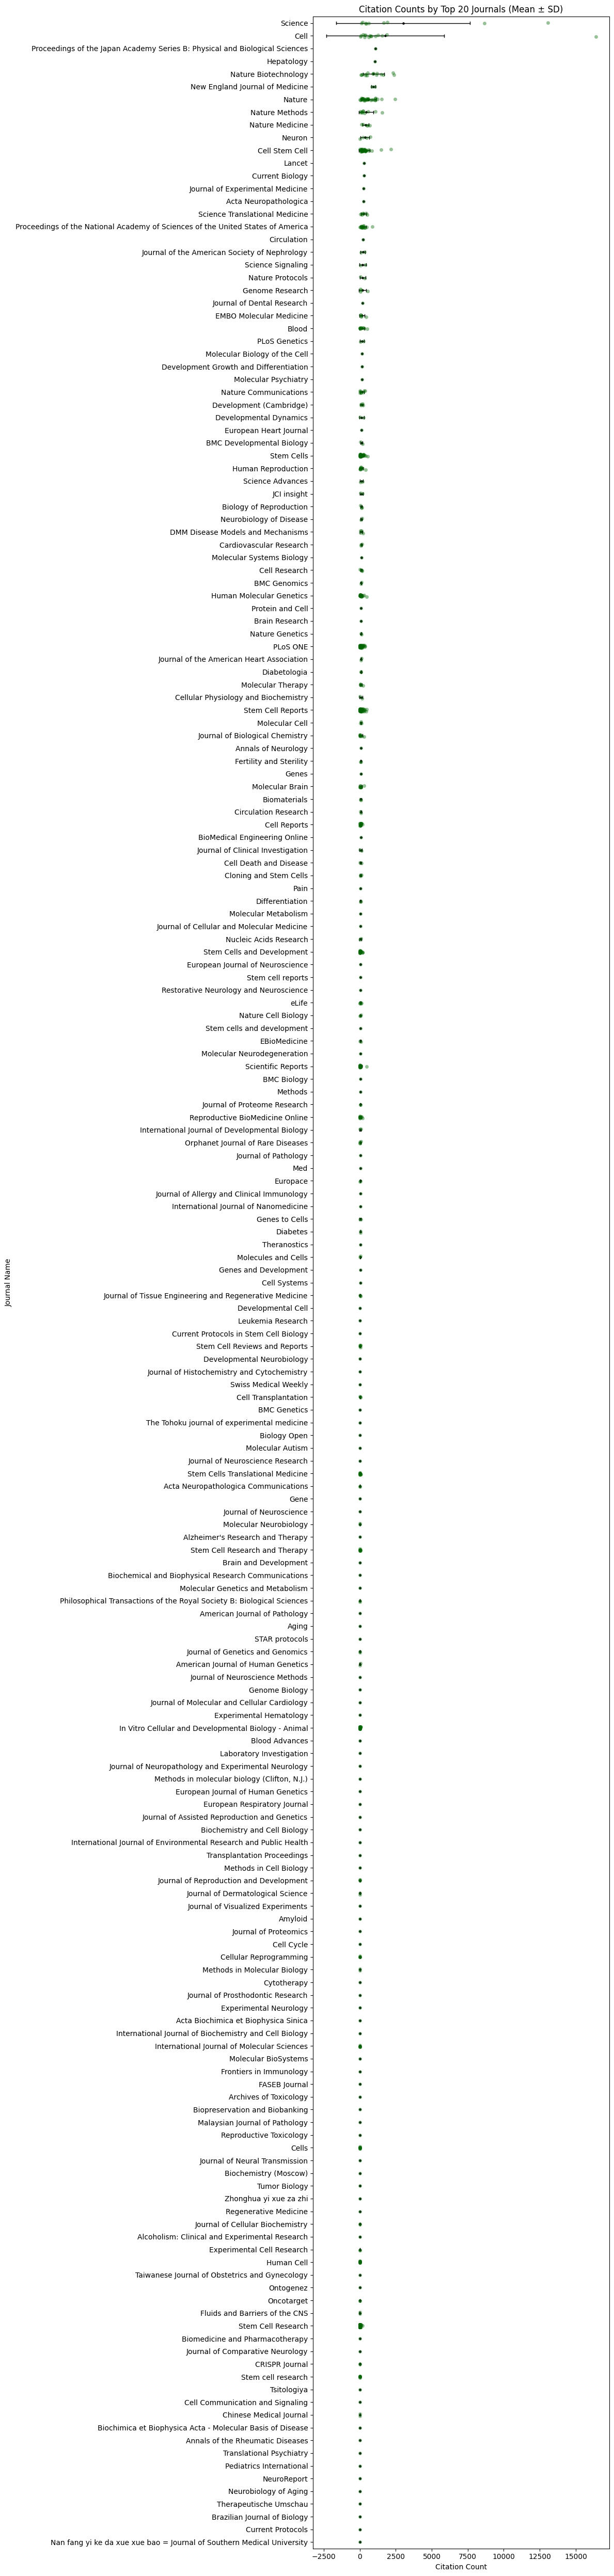

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate top 20 journals by mean citation
journal_mean = (
    Publication.groupby('Journal_Name')['Citation_Count']
    .mean()
    .sort_values(ascending=False)
)
top_30_journals = journal_mean.head(199).index.tolist()

# Step 2: Filter data
df_plot = Publication[Publication['Journal_Name'].isin(top_30_journals)].copy()

# Step 3: Plot
plt.figure(figsize=(12, 50))

# Dot plot
sns.stripplot(
    data=df_plot,
    x='Citation_Count',
    y='Journal_Name',
    order=top_30_journals,
    alpha=0.4,
    jitter=True,
    color='darkgreen'
)

# Mean + error bars
sns.pointplot(
    data=df_plot,
    x='Citation_Count',
    y='Journal_Name',
    order=top_30_journals,
    join=False,
    ci='sd',         # or 'se' for standard error, or 95 for 95% CI
    capsize=0.2,
    color='black',
    linewidth=1
)

plt.title('Citation Counts by Top 20 Journals (Mean ± SD)')
plt.xlabel('Citation Count')
plt.ylabel('Journal Name')
plt.tight_layout()
plt.show()
